# GRAPE for time-dependent hamiltonians

## Simulation

In [1]:
# ruff: noqa
import os

os.sys.path.append("../../../..")

In [2]:
## MAIN.py with time_dep example

import jax
import jax.numpy as jnp
from feedback_grape.grape import (
    optimize_pulse,
    plot_control_amplitudes,
    fidelity,
)
from feedback_grape.utils.solver import sesolve
from feedback_grape.utils.operators import identity, destroy, sigmap, sigmaz
from feedback_grape.utils.tensor import tensor
from feedback_grape.utils.states import basis
# ruff: noqa

N_cav = 10
chi = 0.2385 * (2 * jnp.pi)
mu_qub = 4.0
mu_cav = 8.0
hconj = lambda a: jnp.swapaxes(a.conj(), -1, -2)
time_start = 0.0
time_end = 1.0
time_intervals_num = 5
N_cav = 10
# Eqivalant to delta_ts = jnp.repeat(0.2, time_intervals_num).astype(jnp.float32)
# However, it is implemented in this way to be more general and
# show that these are the differences between the time intervals
t_grid = jnp.linspace(time_start, time_end, time_intervals_num + 1)
delta_ts = t_grid[1:] - t_grid[:-1]
fake_random_key = jax.random.key(seed=0)
e_data = jax.random.uniform(
    fake_random_key, shape=(4, len(delta_ts)), minval=-1, maxval=1
)
e_qub = e_data[0] + 1j * e_data[1]
e_cav = e_data[2] + 1j * e_data[3]


@jax.vmap
def build_ham(e_qub, e_cav):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)

    H_ctrl = mu_qub * sigp * e_qub + mu_cav * adag * e_cav
    H_ctrl += hconj(H_ctrl)
    # You just pass an array of the Hamiltonian matrices "Hs" corresponding to the time
    # intervals "delta_ts" (that is, "Hs" is a 3D array).
    return H0, H_ctrl


H0, H_ctrl = build_ham(e_qub, e_cav)


# Representation for time dependent Hamiltonian
def solve(Hs, delta_ts):
    """
    Find evolution operator for piecewise Hs on time intervals delts_ts
    """
    for i, (H, delta_t) in enumerate(zip(Hs, delta_ts)):
        U_intv = jax.scipy.linalg.expm(-1j * H * delta_t)
        U = U_intv if i == 0 else U_intv @ U
    return U


U = solve(H0 + H_ctrl, delta_ts)
psi0 = tensor(basis(2), basis(N_cav))
global psi_target_qt
psi_target_qt = psi_target = U @ psi0


def build_grape_format_ham():
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    H_ctrl = [H_ctrl_qub, H_ctrl_qub_dag, H_ctrl_cav, H_ctrl_cav_dag]

    return H0, H_ctrl


def test_time_dep(optimizer="adam"):
    H0_grape, H_ctrl_grape = build_grape_format_ham()

    res = optimize_pulse(
        H0_grape,
        H_ctrl_grape,
        psi0,
        psi_target,
        int(
            (time_end - time_start) / delta_ts[0]
        ),  # Ensure this is an integer
        time_end - time_start,
        max_iter=10000,
        # when you decrease convergence threshold, it is more accurate
        convergence_threshold=1e-3,
        learning_rate=1e-2,
        evo_type="state",
        optimizer=optimizer,
    )
    return res

In [3]:
res_fg = test_time_dep("l-bfgs")
print(res_fg.final_fidelity)
print(res_fg.iterations)

0.9976786025906579
147


In [4]:
time_start = 0.0
time_end = 1.0
time_intervals_num = 5

In [5]:
t_grid = jnp.linspace(time_start, time_end, time_intervals_num)

In [6]:
H_labels = [r'$u_1$', r'$u_2$', r'$u_3$', r'$u_4$', r'$u_5$']

In [7]:
t_grid.shape

(5,)

In [8]:
res_fg.control_amplitudes.shape

(5, 4)

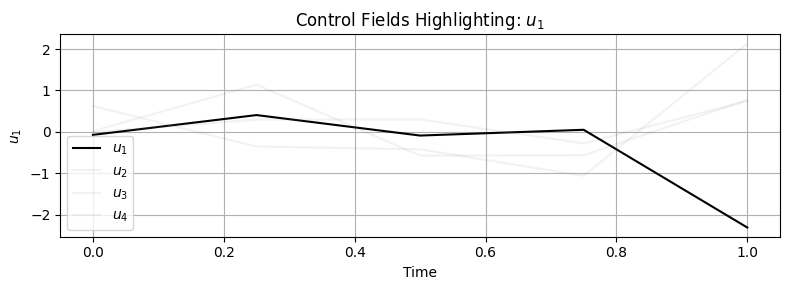

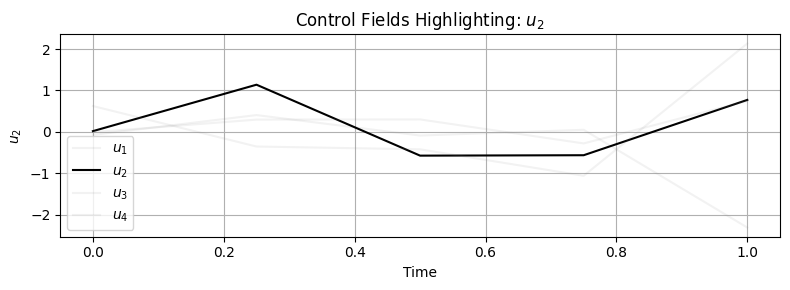

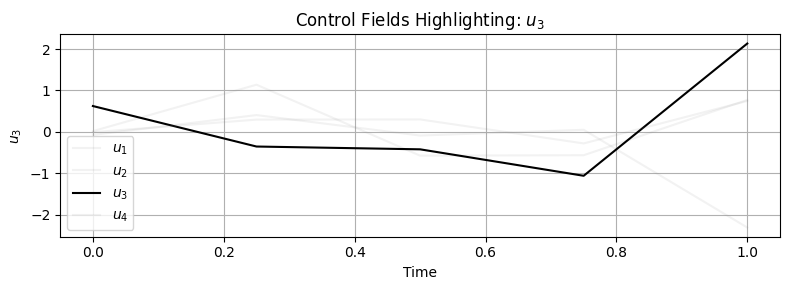

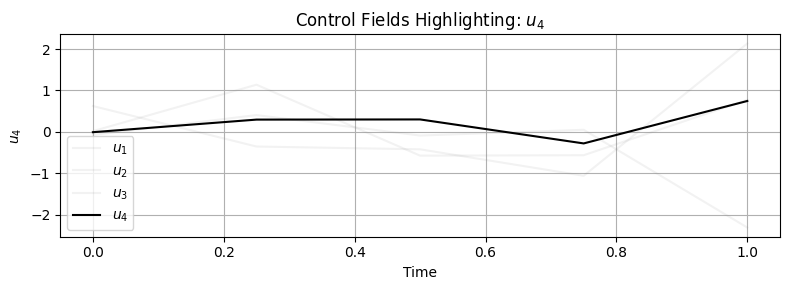

In [9]:
plot_control_amplitudes(t_grid, res_fg.control_amplitudes, labels=H_labels)

In [10]:
res_fg.control_amplitudes

Array([[-0.07032833,  0.01972086,  0.62495471, -0.00556342],
       [ 0.40698173,  1.13940457, -0.35133611,  0.29773951],
       [-0.08669446, -0.57097603, -0.41862371,  0.30195432],
       [ 0.05217747, -0.56101616, -1.05672015, -0.27651302],
       [-2.30432846,  0.77224721,  2.13210575,  0.74677139]],      dtype=float64)

## Example of user trying to construct his time dependent Hamiltonian from extracted amplitudes and then get the final operator

<img src="../../_static/notebook-images/time_det_tut.png" width="800"/>

### Define the time grid (same as defined)

In [11]:
time_start = 0.0
time_end = 1.0
time_intervals_num = 5
N_cav = 10
# Eqivalant to delta_ts = jnp.repeat(0.2, time_intervals_num).astype(jnp.float32)
# However, it is implemented in this way to be more general and
# show that these are the differences between the time intervals
t_grid = jnp.linspace(time_start, time_end, time_intervals_num + 1)
delta_ts = t_grid[1:] - t_grid[:-1]

### Build the Hamiltonian

In [12]:
def build_ham_reconstructed(u1, u2, u3, u4):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    # Apply control amplitudes
    H_ctrl = (
        u1 * H_ctrl_qub
        + u2 * H_ctrl_qub_dag
        + u3 * H_ctrl_cav
        + u4 * H_ctrl_cav_dag
    )

    H = H0 + H_ctrl
    return H

In [13]:
u1 = res_fg.control_amplitudes[:, 0]
u2 = res_fg.control_amplitudes[:, 1]
u3 = res_fg.control_amplitudes[:, 2]
u4 = res_fg.control_amplitudes[:, 3]

In [14]:
u1

Array([-0.07032833,  0.40698173, -0.08669446,  0.05217747, -2.30432846],      dtype=float64)

### Construct the Hamiltonian for each time step

In [15]:
H_total = jnp.array(
    [
        build_ham_reconstructed(u1[i], u2[i], u3[i], u4[i])
        for i in range(len(u1))
    ]
)

In [16]:
H_total

Array([[[ 0.00000000e+00+0.j, -4.45073973e-02+0.j,  0.00000000e+00+0.j,
         ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 4.99963768e+00+0.j,  1.49853970e+00+0.j, -6.29429649e-02+0.j,
         ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  7.07055541e+00+0.j,  2.99707939e+00+0.j,
         ...,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        ...,
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         ...,  0.00000000e+00+0.j, -1.25885930e-01+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         ...,  1.41411108e+01+0.j,  0.00000000e+00+0.j,
         -1.33522192e-01+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         ...,  0.00000000e+00+0.j,  1.49989130e+01+0.j,
          0.00000000e+00+0.j]],

       [[ 0.00000000e+00+0.j,  

In [17]:
H_total.shape

(5, 20, 20)

### Solve the Schrödinger Equation

In [18]:
psi0_fg = tensor(basis(2), basis(N_cav))
psi_fg = sesolve(H_total, psi0_fg, delta_ts, evo_type="state")

### Calculate fidelity with target

In [19]:
print(fidelity(C_target=psi_target, U_final=psi_fg, evo_type="state"))

0.9976786025906581
